Import packages and neighborhood labeled data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


In [2]:
save_path = 'G:/HuBMAP/B008_12/analysis/context/'
df = pd.read_csv("G:/HuBMAP/B008_12/Neighborhoods/05_25_HuBMAP_tunit.csv", index_col=0)
df.columns

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (62,63,70) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15', 'CHGA',
       'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR', 'CD8', 'CD11c',
       'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38', 'CD90', 'aSMA', 'CD21',
       'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68', 'CD34', 'aDef5', 'CD7',
       'CD36', 'CD138', 'CD45RO', 'Cytokeratin', 'CD117', 'CD19', 'Podoplanin',
       'CD45', 'CD56', 'CD69', 'Ki67', 'CD49a', 'CD163', 'CD161',
       'first_index', 'x', 'y', 'tissue', 'donor', 'region', 'OLFM4', 'FAP',
       'CD25', 'CollIV', 'CK7', 'Xcorr', 'Ycorr', 'unique_region',
       'neigh_name', 'neigh_sub1', 'Preservation_method', 'Tissue_location',
       'array', 'Cell Type', 'Cell Type em', 'Cell subtype', 'machine', 'MUC6',
       'Neighborhood', 'Neighborhood_Ind', 'Neigh_sub', 'NeighInd_sub',
       'Community', 'Major Community', 'Tissue Segment', 'Tissue Unit'],
      dtype='object')

In [28]:
#Color dictionaries to use for consistency
cell_map = {
    'NK': 'blue',
 'Enterocyte': 'magenta',
 'MUC1+ Enterocyte': 'yellow',
 'TA': 'skyblue',
 'CD66+ Enterocyte': 'darkorange',
 'Paneth': 'green',
 'Smooth muscle': 'red',
 'Cycling TA': 'tan',
 'M1 Macrophage': 'gray',
 'Goblet': 'indigo',
 'Neuroendocrine': 'yellowgreen',
 'CD57+ Enterocyte': 'lightsalmon',
 'Lymphatic': 'plum',
 'CD8+ T': 'gold',
 'DC': 'blueviolet',
 'M2 Macrophage': 'bisque',
 'B': 'navy',
 'Neutrophil': 'goldenrod',
 'Endothelial': 'black',
 'Plasma': 'yellow',
 'CD4+ T cell': 'brown',
 'Stroma': 'dimgray',
 'Nerve': 'olive',
 'ICC': 'teal',
 'CD7+ Immune': 'lightcoral'}


neigh_map = {
 'Transit Amplifying Zone': 'darkblue',
 'Microvasculature': 'black',
 'Adaptive Immune Enriched': 'orange',
 'Glandular Epithelial': 'darkorange',
 'CD66+ Mature Epithelial': 'firebrick',
 'Stroma & Innate Immune': 'brown',
 'CD8+ T Enriched IEL': 'green',
 'Mature Epithelial': 'magenta',
 'Innate Immune Enriched': 'skyblue',
 'Outer Follicle': 'navy',
 'Plasma Cell Enriched': 'yellow',
 'Innervated Stroma': 'blueviolet',
 'Stroma': 'gray',
 'Macrovasculature': 'gold',
 'Secretory Epithelial': 'yellowgreen',
 'Smooth Muscle': 'red',
 'Innervated Smooth Muscle': 'lightgreen',
 'Inner Follicle': 'blue',
 'Smooth Muscle & Innate Immune': 'tan',
 'Paneth Enriched': 'lightblue'}


comm_map = {'Plasma Cell Enriched': 'yellow',
 'Mature Epithelial': 'magenta',
 'Innate Immune Enriched': 'brown',
 'Stroma': 'gray',
 'Follicle': 'blue',
 'Adaptive Immune Enriched': 'orange',
 'Smooth Muscle': 'red',
 'Secretory Epithelial': 'purple',
 'CD66+ Mature Epithelial': 'teal',
 'CD8+ T Enriched IEL': 'green'}

tissue_map = {
 'Submucosa': 'blue',
 'Muscularis externa': 'orange',
 'Muscularis mucosa': 'red',
 'Mucosa': 'green'
}

## Test out the graph building process

In [3]:
##commorhood to Community

#Get Percentages of the comm type or probabilities that is in each neigbhorhood
group_comm = df.groupby(['Community']).apply(lambda x: x['Tissue Unit'].value_counts(normalize = True,sort = False)*100)
comm = group_comm.unstack().fillna(0)
comm_s = comm.reset_index()
comm_m = comm_s.melt(id_vars = 'Community')

#Add in percentages of the commorhoods and comm types
df_maj_count = df['Tissue Unit'].value_counts(normalize=True) * 100
df_comm_count = df['Community'].value_counts(normalize=True) * 100
df_maj_merge = df_maj_count.to_frame()
df_comm_merge = df_comm_count.to_frame()
df_comm_merge.reset_index(inplace=True)
df_maj_merge.reset_index(inplace=True)
df_comm_merge.columns = ['Community', 'maj_per']
df_maj_merge.columns = ['Tissue Unit', 'overall_per']

#Add max of each Community and also above a certain threshold
comm_max = comm_m.loc[comm_m.groupby('Community')['value'].idxmax()]
comm_max_2 = comm_m.loc[comm_m.groupby('variable')['value'].idxmax()]
comm_thres = comm_m.loc[comm_m.value>25]
comm_merge = pd.concat([comm_max, comm_thres,comm_max_2])
comm_dup = comm_merge.drop_duplicates()
comm_dup.rename(columns={'variable':'Tissue Unit','value':'probability'}, inplace=True)
comm_graph = pd.merge(comm_dup,df_maj_merge, on='Tissue Unit')
comm_graph1= pd.merge(comm_graph,df_comm_merge, on='Community')

#make CN unique from the Community
comm_graph1['Community'] = comm_graph1['Community']+'_cm'
comm_graph1['Tissue Unit'] = comm_graph1['Tissue Unit']+'_co'

#adjusting values so presentable in the graph
comm_graph1['width'] = comm_graph1['probability']/5
comm_graph1['node_m'] = comm_graph1['maj_per']*30
comm_graph1['node_o'] = comm_graph1['overall_per']*30
comm_graph1['line_p'] = comm_graph1['probability']/10
comm_graph1

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Community,Tissue Unit,probability,overall_per,maj_per,width,node_m,node_o,line_p
0,Adaptive Immune Enriched_cm,Mucosa_co,82.639042,69.882309,9.199794,16.527808,275.993809,2096.469270,8.263904
1,Adaptive Immune Enriched_cm,Muscularis mucosa_co,17.360958,6.054215,9.199794,3.472192,275.993809,181.626448,1.736096
2,CD66+ Mature Epithelial_cm,Mucosa_co,99.896130,69.882309,2.414528,19.979226,72.435850,2096.469270,9.989613
3,CD8+ T Enriched IEL_cm,Mucosa_co,98.207573,69.882309,9.403496,19.641515,282.104871,2096.469270,9.820757
4,Follicle_cm,Mucosa_co,96.532623,69.882309,4.125116,19.306525,123.753484,2096.469270,9.653262
5,Innate Immune Enriched_cm,Mucosa_co,88.138795,69.882309,5.078977,17.627759,152.369305,2096.469270,8.813879
6,Mature Epithelial_cm,Mucosa_co,99.721356,69.882309,5.886102,19.944271,176.583060,2096.469270,9.972136
7,Plasma Cell Enriched_cm,Mucosa_co,97.607813,69.882309,19.167341,19.521563,575.020243,2096.469270,9.760781
8,Secretory Epithelial_cm,Mucosa_co,98.126716,69.882309,17.931475,19.625343,537.944237,2096.469270,9.812672
9,Smooth Muscle_cm,Muscularis externa_co,84.084959,13.962011,15.966787,16.816992,479.003600,418.860335,8.408496


In [4]:
##Neighborhood to Community

#Get Percentages of the neighb type or probabilities that is in each neigbhorhood
group_neighb = df.groupby(['Neighborhood']).apply(lambda x: x['Community'].value_counts(normalize = True,sort = False)*100)
neighb = group_neighb.unstack().fillna(0)
neighb_s = neighb.reset_index()
neighb_m = neighb_s.melt(id_vars = 'Neighborhood')

#Add in percentages of the neighborhoods and neighb types
df_maj_count = df['Community'].value_counts(normalize=True) * 100
df_neighb_count = df['Neighborhood'].value_counts(normalize=True) * 100
df_maj_merge = df_maj_count.to_frame()
df_neighb_merge = df_neighb_count.to_frame()
df_neighb_merge.reset_index(inplace=True)
df_maj_merge.reset_index(inplace=True)
df_neighb_merge.columns = ['Neighborhood', 'neigh_per']
df_maj_merge.columns = ['Community', 'major_per']

#Add max of each Neighborhood and also above a certain threshold
neighb_max = neighb_m.loc[neighb_m.groupby('Neighborhood')['value'].idxmax()]
neighb_max_2 = neighb_m.loc[neighb_m.groupby('variable')['value'].idxmax()]
neighb_thres = neighb_m.loc[neighb_m.value>25]
neighb_merge = pd.concat([neighb_max, neighb_thres,neighb_max_2])
neighb_dup = neighb_merge.drop_duplicates()
neighb_dup.rename(columns={'variable':'Community','value':'probability'}, inplace=True)
neighb_graph = pd.merge(neighb_dup,df_maj_merge, on='Community')
neighb_graph1= pd.merge(neighb_graph,df_neighb_merge, on='Neighborhood')

#make CN unique from the Neighborhood
neighb_graph1['Neighborhood'] = neighb_graph1['Neighborhood']+'_cn'
neighb_graph1['Community'] = neighb_graph1['Community']+'_cm'

#adjusting values so presentable in the graph
neighb_graph1['width'] = neighb_graph1['probability']/5
neighb_graph1['node_n'] = neighb_graph1['neigh_per']*30
neighb_graph1['node_m'] = neighb_graph1['major_per']*30
neighb_graph1['line_p'] = neighb_graph1['probability']/10
neighb_graph1

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Neighborhood,Community,probability,major_per,neigh_per,width,node_n,node_m,line_p
0,Adaptive Immune Enriched_cn,Adaptive Immune Enriched_cm,24.222324,9.199794,4.099002,4.844465,122.970045,275.993809,2.422232
1,Glandular Epithelial_cn,Adaptive Immune Enriched_cm,60.889381,9.199794,0.611425,12.177876,18.342740,275.993809,6.088938
2,Paneth Enriched_cn,Adaptive Immune Enriched_cm,81.819715,9.199794,1.180015,16.363943,35.400450,275.993809,8.181972
3,CD66+ Mature Epithelial_cn,CD66+ Mature Epithelial_cm,70.831277,2.414528,2.258438,14.166255,67.753131,72.435850,7.083128
4,CD8+ T Enriched IEL_cn,CD8+ T Enriched IEL_cm,62.998845,9.403496,6.722327,12.599769,201.669824,282.104871,6.299885
5,Innate Immune Enriched_cn,Innate Immune Enriched_cm,36.960643,5.078977,3.317673,7.392129,99.530176,152.369305,3.696064
6,Inner Follicle_cn,Follicle_cm,90.237791,4.125116,1.588733,18.047558,47.661984,123.753484,9.023779
7,Outer Follicle_cn,Follicle_cm,40.051349,4.125116,3.705730,8.010270,111.171886,123.753484,4.005135
8,Innervated Smooth Muscle_cn,Smooth Muscle_cm,75.006627,15.966787,3.454257,15.001325,103.627704,479.003600,7.500663
9,Innervated Stroma_cn,Smooth Muscle_cm,47.547708,15.966787,1.368470,9.509542,41.054107,479.003600,4.754771


In [5]:
##Cell to Neighborhood

#Get Percentages of the cell type or probabilities that is in each neigbhorhood
group_cell = df.groupby(['Cell Type']).apply(lambda x: x['Neighborhood'].value_counts(normalize = True,sort = False)*100)
Cell = group_cell.unstack().fillna(0)
Cell_s = Cell.reset_index()
Cell_m = Cell_s.melt(id_vars = 'Cell Type')

#Add in percentages of the neighborhoods and cell types
df_neigh_count = df['Neighborhood'].value_counts(normalize=True) * 100
df_cell_count = df['Cell Type'].value_counts(normalize=True) * 100
df_neigh_merge = df_neigh_count.to_frame()
df_cell_merge = df_cell_count.to_frame()
df_cell_merge.reset_index(inplace=True)
df_neigh_merge.reset_index(inplace=True)
df_cell_merge.columns = ['Cell Type', 'cell_per']
df_neigh_merge.columns = ['Neighborhood', 'neigh_per']

#Add max of each cell type and also above a certain threshold
Cell_max = Cell_m.loc[Cell_m.groupby('Cell Type')['value'].idxmax()]
Cell_max_2 = Cell_m.loc[Cell_m.groupby('variable')['value'].idxmax()]
Cell_thres = Cell_m.loc[Cell_m.value>15]
Cell_merge = pd.concat([Cell_max, Cell_thres, Cell_max_2])
Cell_dup = Cell_merge.drop_duplicates()
Cell_dup.rename(columns={'variable':'Neighborhood','value':'probability'}, inplace=True)
cell_graph = pd.merge(Cell_dup,df_neigh_merge, on='Neighborhood')
cell_graph1= pd.merge(cell_graph,df_cell_merge, on='Cell Type')

#make CN unique from the cell type
cell_graph1['Neighborhood'] = cell_graph1['Neighborhood']+'_cn'

#adjusting values so presentable in the graph
cell_graph1['width'] = cell_graph1['probability']/5
cell_graph1['node_c'] = cell_graph1['cell_per']*30
cell_graph1['node_n'] = cell_graph1['neigh_per']*30
cell_graph1['line_p'] = cell_graph1['probability']/10
cell_graph1

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Cell Type,Neighborhood,probability,neigh_per,cell_per,width,node_c,node_n,line_p
0,B,Inner Follicle_cn,63.649680,1.588733,1.413176,12.729936,42.395269,47.661984,6.364968
1,CD4+ T cell,Outer Follicle_cn,34.158577,3.705730,4.658277,6.831715,139.748296,111.171886,3.415858
2,CD4+ T cell,Plasma Cell Enriched_cn,20.759554,11.042228,4.658277,4.151911,139.748296,331.266854,2.075955
3,CD57+ Enterocyte,Transit Amplifying Zone_cn,34.142480,11.625429,0.075438,6.828496,2.263135,348.762859,3.414248
4,CD57+ Enterocyte,Glandular Epithelial_cn,17.678100,0.611425,0.075438,3.535620,2.263135,18.342740,1.767810
5,Cycling TA,Transit Amplifying Zone_cn,70.425850,11.625429,3.298007,14.085170,98.940208,348.762859,7.042585
6,Cycling TA,Secretory Epithelial_cn,16.761220,11.184068,3.298007,3.352244,98.940208,335.522026,1.676122
7,Neuroendocrine,Transit Amplifying Zone_cn,37.601870,11.625429,0.595939,7.520374,17.878170,348.762859,3.760187
8,Neuroendocrine,Secretory Epithelial_cn,25.210421,11.184068,0.595939,5.042084,17.878170,335.522026,2.521042
9,TA,Transit Amplifying Zone_cn,54.768726,11.625429,2.278979,10.953745,68.369372,348.762859,5.476873


Import modules from cellhier for neighborhoods

ValueError: Received invalid argument(s): edges

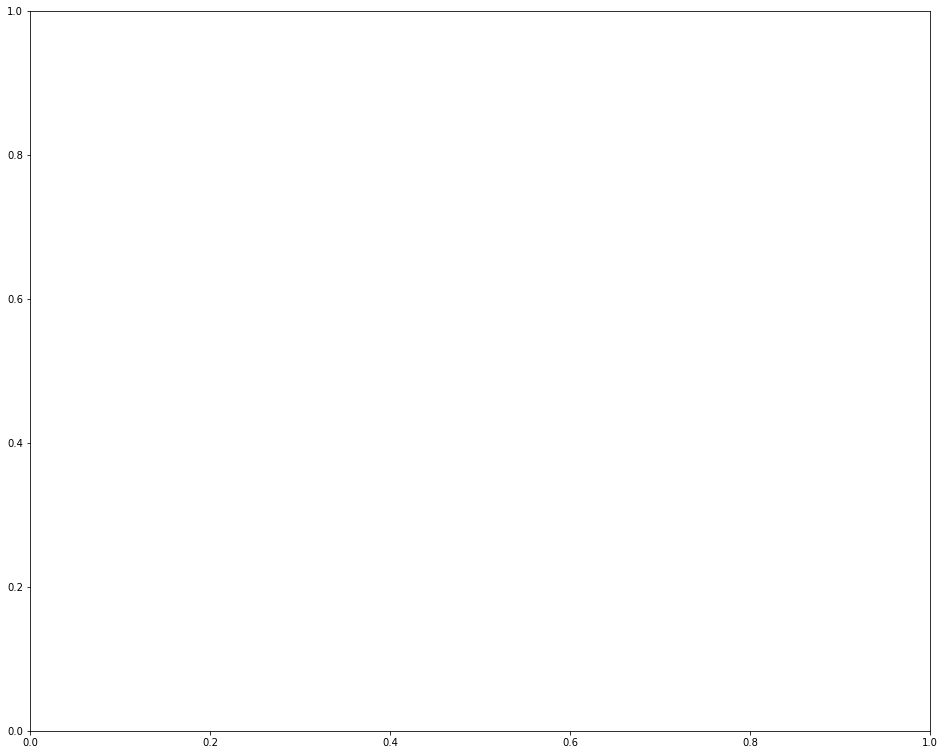

In [16]:
G5 = nx.DiGraph()
for i, row in comm_graph1.iterrows():
    G5.add_edge(row['Community'], row['Tissue Unit'])

edges5 = G5.edges
pos5 = nx.drawing.nx_pydot.graphviz_layout(G5, prog='dot')   
nx.draw(G5, edges= edges5, pos=pos5)

ValueError: Received invalid argument(s): edges

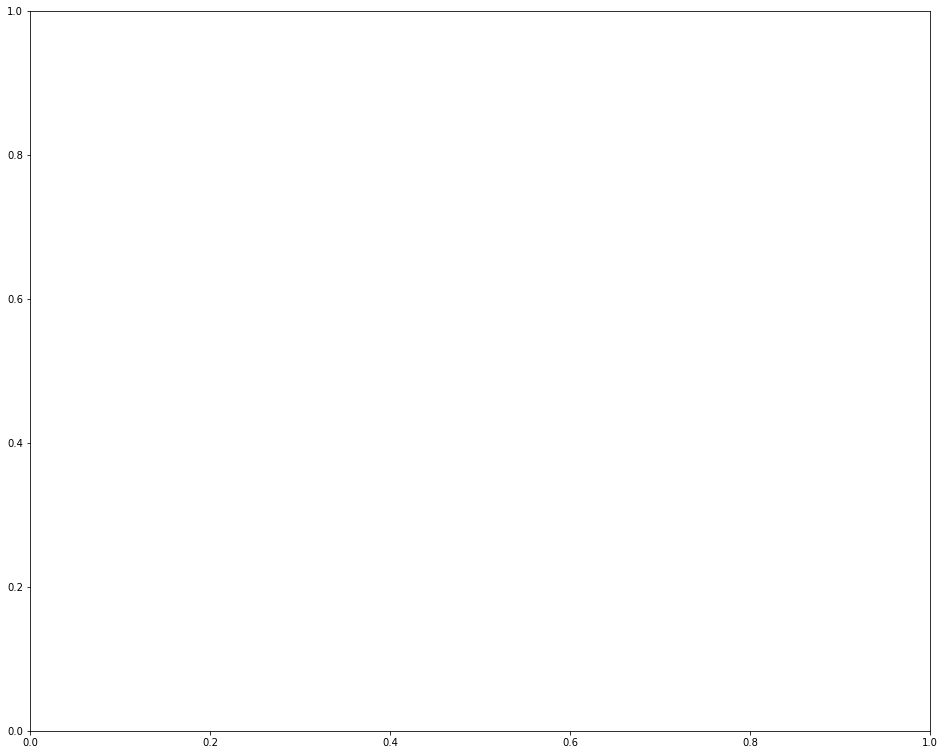

In [17]:
G3 = nx.DiGraph()
for i, row in neighb_graph1.iterrows():
    G3.add_edge(row['Neighborhood'], row['Community'])

edges3 = G3.edges
pos3 = nx.drawing.nx_pydot.graphviz_layout(G3, prog='dot')   
nx.draw(G3, edges= edges3, pos=pos3)

ValueError: Received invalid argument(s): edges

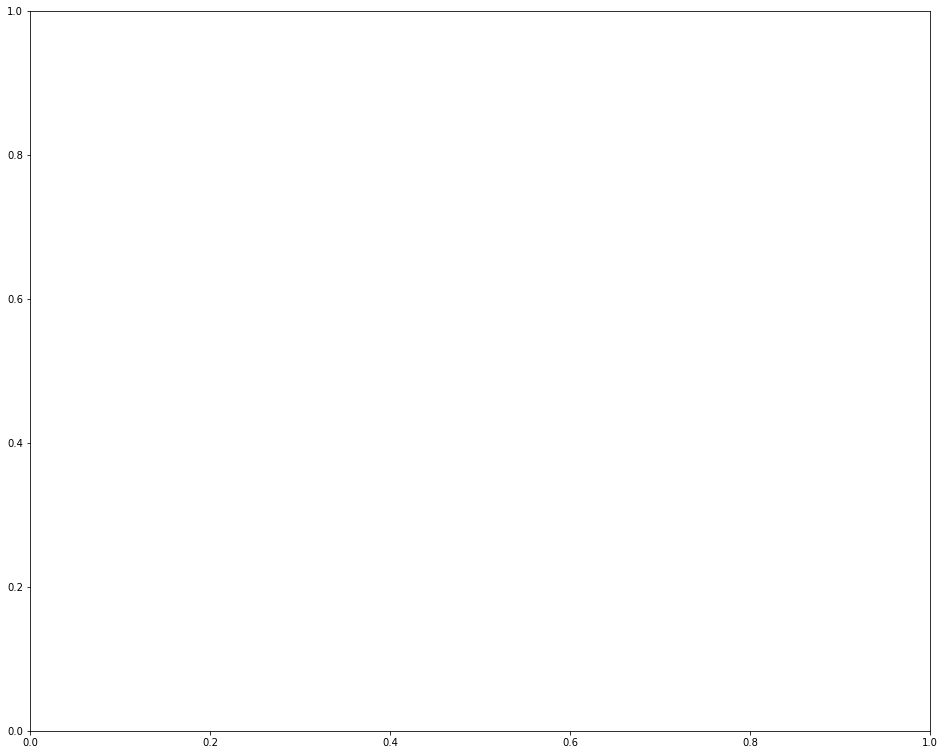

In [18]:
G2 = nx.DiGraph()
for i, row in cell_graph1.iterrows():
    G2.add_edge(row['Cell Type'], row['Neighborhood'])

edges2 = G2.edges
pos2 = nx.drawing.nx_pydot.graphviz_layout(G2, prog='dot')   
nx.draw(G2, edges= edges2, pos=pos2)

ValueError: Received invalid argument(s): edges

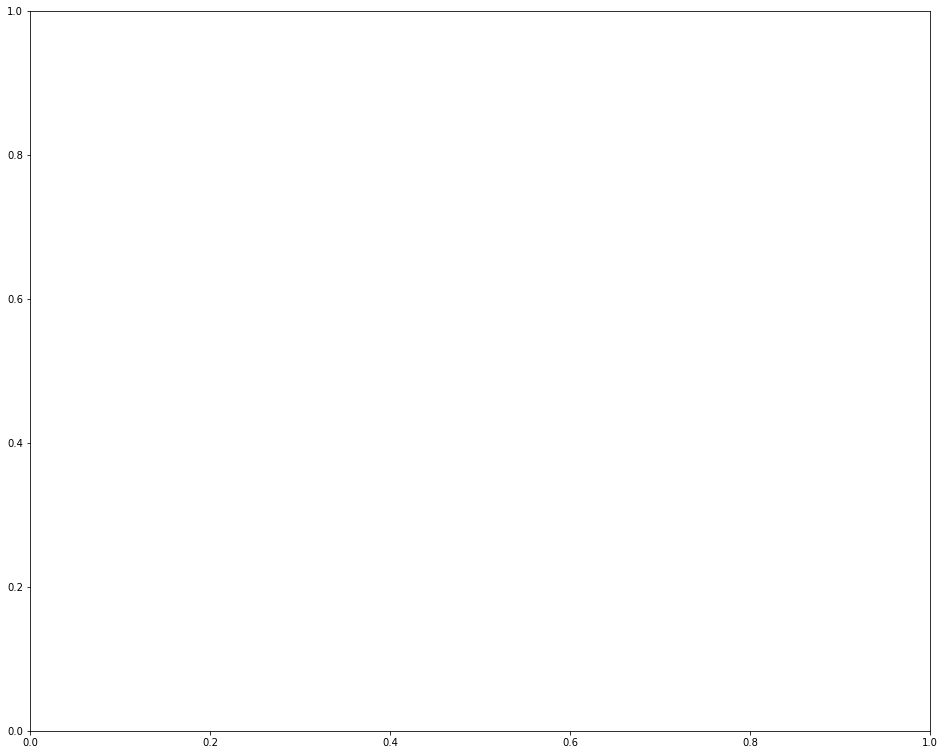

In [19]:
G4 = nx.DiGraph()
for i, row in cell_graph1.iterrows():
    G4.add_edge(row['Cell Type'], row['Neighborhood'])

for i, row in neighb_graph1.iterrows():
    G4.add_edge(row['Neighborhood'], row['Community'])
    
for i, row in comm_graph1.iterrows():
    G4.add_edge(row['Community'], row['Tissue Unit'])

edges4 = G4.edges
pos4 = nx.drawing.nx_pydot.graphviz_layout(G4, prog='dot')   
nx.draw(G4, edges= edges4, pos=pos4)

In [11]:
sub_cell = cell_graph1.drop_duplicates(subset='Cell Type', keep="last")
sub_neigh = cell_graph1.drop_duplicates(subset='Neighborhood', keep="last")
sub_maj = neighb_graph1.drop_duplicates(subset='Community', keep="last")
sub_ov = comm_graph1.drop_duplicates(subset='Tissue Unit', keep="last")

dict_node_size = dict(zip(sub_cell['Cell Type'],sub_cell['node_c']))
dict_node_neigh = dict(zip(sub_neigh['Neighborhood'],sub_neigh['node_n']))
dict_node_maj = dict(zip(sub_maj['Community'],sub_maj['node_m']))
dict_node_ov = dict(zip(sub_ov['Tissue Unit'],sub_ov['node_o']))
dict_node_size.update(dict_node_neigh)
dict_node_size.update(dict_node_maj)
dict_node_size.update(dict_node_ov)

dict_shape = {}
dict_shape_c = {}
dict_shape_m = {}
dict_shape_o = {}
for i, row in cell_graph1.iterrows():
    dict_shape[row['Neighborhood']] = 's'
    dict_shape_c[row['Cell Type']] = 'o'          
dict_shape.update(dict_shape_c)
for i, row in neighb_graph1.iterrows():
    dict_shape_m[row['Community']] = '^'
dict_shape.update(dict_shape_m)
for i, row in comm_graph1.iterrows():
    dict_shape_o[row['Tissue Unit']] = 'D'
dict_shape.update(dict_shape_o)
    
dict_weight = {}
dict_weight_m = {}
dict_weight_o = {}
for i, row in cell_graph1.iterrows():
    dict_weight[(row['Cell Type'], row['Neighborhood'])] = row['line_p']
for i, row in neighb_graph1.iterrows():
    dict_weight_m[(row['Neighborhood'], row['Community'])] = row['line_p']
dict_weight.update(dict_weight_m)
for i, row in comm_graph1.iterrows():
    dict_weight_o[(row['Community'], row['Tissue Unit'])] = row['line_p']
dict_weight.update(dict_weight_o)
dict_weight

{('B', 'Inner Follicle_cn'): 6.3649680272683735,
 ('CD4+ T cell', 'Outer Follicle_cn'): 3.415857660490873,
 ('CD4+ T cell', 'Plasma Cell Enriched_cn'): 2.075955424899159,
 ('CD57+ Enterocyte', 'Transit Amplifying Zone_cn'): 3.41424802110818,
 ('CD57+ Enterocyte', 'Glandular Epithelial_cn'): 1.7678100263852243,
 ('Cycling TA', 'Transit Amplifying Zone_cn'): 7.042585037298119,
 ('Cycling TA', 'Secretory Epithelial_cn'): 1.6761219612292688,
 ('Neuroendocrine', 'Transit Amplifying Zone_cn'): 3.760187040748163,
 ('Neuroendocrine', 'Secretory Epithelial_cn'): 2.5210420841683367,
 ('TA', 'Transit Amplifying Zone_cn'): 5.476872554499721,
 ('TA', 'Secretory Epithelial_cn'): 2.273092509782001,
 ('CD7+ Immune', 'Transit Amplifying Zone_cn'): 1.9487036520769447,
 ('CD7+ Immune', 'CD8+ T Enriched IEL_cn'): 2.2135489266796764,
 ('CD7+ Immune', 'Secretory Epithelial_cn'): 1.8079174797881237,
 ('Enterocyte', 'Transit Amplifying Zone_cn'): 2.1103165485135813,
 ('Enterocyte', 'Mature Epithelial_cn'): 3.

In [29]:
do = {k+'_co': v for k, v in tissue_map.items()}
dm = {k+'_cm': v for k, v in comm_map.items()}
dn = {k+'_cn': v for k, v in neigh_map.items()}

cell_map.update(do)
cell_map.update(dm)
cell_map.update(dn)
pal_color=cell_map
pal_color

{'NK': 'blue',
 'Enterocyte': 'magenta',
 'MUC1+ Enterocyte': 'yellow',
 'TA': 'skyblue',
 'CD66+ Enterocyte': 'darkorange',
 'Paneth': 'green',
 'Smooth muscle': 'red',
 'Cycling TA': 'tan',
 'M1 Macrophage': 'gray',
 'Goblet': 'indigo',
 'Neuroendocrine': 'yellowgreen',
 'CD57+ Enterocyte': 'lightsalmon',
 'Lymphatic': 'plum',
 'CD8+ T': 'gold',
 'DC': 'blueviolet',
 'M2 Macrophage': 'bisque',
 'B': 'navy',
 'Neutrophil': 'goldenrod',
 'Endothelial': 'black',
 'Plasma': 'yellow',
 'CD4+ T cell': 'brown',
 'Stroma': 'dimgray',
 'Nerve': 'olive',
 'ICC': 'teal',
 'CD7+ Immune': 'lightcoral',
 'Submucosa_co': 'blue',
 'Muscularis externa_co': 'orange',
 'Muscularis mucosa_co': 'red',
 'Mucosa_co': 'green',
 'Plasma Cell Enriched_cm': 'yellow',
 'Mature Epithelial_cm': 'magenta',
 'Innate Immune Enriched_cm': 'brown',
 'Stroma_cm': 'gray',
 'Follicle_cm': 'blue',
 'Adaptive Immune Enriched_cm': 'orange',
 'Smooth Muscle_cm': 'red',
 'Secretory Epithelial_cm': 'purple',
 'CD66+ Mature Epi

(-160.55734999999999, 4563.95035, 7.199999999999999, 244.8)

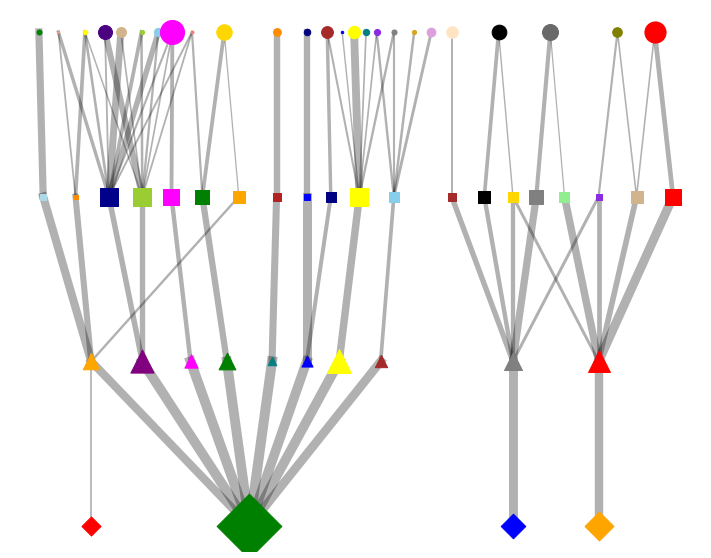

In [31]:
figsize(12.5,10)
for n in G4.nodes():
    plt.scatter([pos4[n][0]],[pos4[n][1]],c = pal_color[n] , zorder = 5,s = dict_node_size[n], marker=dict_shape[n])
    
for e0,e1 in G4.edges():
    weight = 0.2
    alpha = .3
    color='black'
    plt.plot([pos4[e0][0], pos4[e1][0]],[pos4[e0][1], pos4[e1][1]], color = color, 
             linewidth = dict_weight[(e0,e1)],alpha = alpha,zorder = -10)

plt.axis('off')
#plt.show()
#plt.savefig(save_path+'hierarcy_map.pdf')

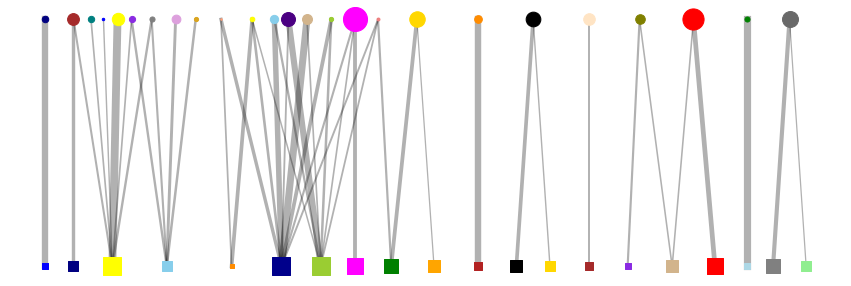

In [32]:
figsize(15,5)
for n in G2.nodes():
    plt.scatter([pos2[n][0]],[pos2[n][1]],c = pal_color[n] , zorder = 5,s = dict_node_size[n], marker=dict_shape[n])
    
for e0,e1 in G2.edges():
    weight = 0.2
    alpha = .3
    color='black'
    plt.plot([pos2[e0][0], pos2[e1][0]],[pos2[e0][1], pos2[e1][1]], color = color, 
             linewidth = dict_weight[(e0,e1)],alpha = alpha,zorder = -10)

plt.axis('off')
plt.show()

## Build the graphs with functions

In [34]:
def graph_connection(data, level_0, level_1, connection_threshold, level_symbol):
    #Get Percentages of the comm type or probabilities that is in each neigbhorhood
    group_comm = data.groupby([level_0]).apply(lambda x: x[level_1].value_counts(normalize = True,sort = False)*100)
    comm = group_comm.unstack().fillna(0)
    comm_s = comm.reset_index()
    comm_m = comm_s.melt(id_vars = level_0)

    level_0_per = level_0 +'_per'
    level_1_per = level_1 +'_per'
    
    #Add in percentages of the commorhoods and comm types
    df_maj_count = df[level_1].value_counts(normalize=True) * 100
    df_comm_count = df[level_0].value_counts(normalize=True) * 100
    df_maj_merge = df_maj_count.to_frame()
    df_comm_merge = df_comm_count.to_frame()
    df_comm_merge.reset_index(inplace=True)
    df_maj_merge.reset_index(inplace=True)
    df_comm_merge.columns = [level_0, level_0_per]
    df_maj_merge.columns = [level_1, level_1_per]

    #Add max of each Community and also above a certain threshold
    comm_max = comm_m.loc[comm_m.groupby(level_0)['value'].idxmax()]
    comm_max_2 = comm_m.loc[comm_m.groupby('variable')['value'].idxmax()]
    comm_thres = comm_m.loc[comm_m.value>connection_threshold]
    comm_merge = pd.concat([comm_max, comm_thres,comm_max_2])
    comm_dup = comm_merge.drop_duplicates()
    comm_dup.rename(columns={'variable':level_1,'value':'probability'}, inplace=True)
    comm_graph = pd.merge(comm_dup,df_maj_merge, on=level_1)
    comm_graph1= pd.merge(comm_graph,df_comm_merge, on=level_0)

    #make CN unique from the Community
    comm_graph1[level_0] = comm_graph1[level_0]+level_symbol[0]
    comm_graph1[level_1] = comm_graph1[level_1]+level_symbol[1]

    #adjusting values so presentable in the graph
    comm_graph1['width'] = comm_graph1['probability']/5
    comm_graph1['node'+level_0] = comm_graph1[level_0_per]*30
    comm_graph1['node'+level_1] = comm_graph1[level_1_per]*30
    comm_graph1['line_p'] = comm_graph1['probability']/10
    return comm_graph1

In [36]:
def build_dict(data_levels, data_names):
    sub_cell = data_levels[0].drop_duplicates(subset=data_names[0], keep="last")
    sub_neigh = data_levels[0].drop_duplicates(subset=data_names[1], keep="last")
    sub_maj = data_levels[1].drop_duplicates(subset=data_names[2], keep="last")
    sub_ov = data_levels[2].drop_duplicates(subset=data_names[3], keep="last")

    dict_node_size = dict(zip(sub_cell[data_names[0]],sub_cell['node'+data_names[0]]))
    dict_node_neigh = dict(zip(sub_neigh[data_names[1]],sub_neigh['node'+data_names[1]]))
    dict_node_maj = dict(zip(sub_maj[data_names[2]],sub_maj['node'+data_names[2]]))
    dict_node_ov = dict(zip(sub_ov[data_names[3]],sub_ov['node'+data_names[3]]))
    dict_node_size.update(dict_node_neigh)
    dict_node_size.update(dict_node_maj)
    dict_node_size.update(dict_node_ov)

    dict_shape = {}
    dict_shape_c = {}
    dict_shape_m = {}
    dict_shape_o = {}
    for i, row in data_levels[0].iterrows():
        dict_shape[row[data_names[1]]] = 's'
        dict_shape_c[row[data_names[0]]] = 'o'          
    dict_shape.update(dict_shape_c)
    for i, row in data_levels[1].iterrows():
        dict_shape_m[row[data_names[2]]] = '^'
    dict_shape.update(dict_shape_m)
    for i, row in data_levels[2].iterrows():
        dict_shape_o[row[data_names[3]]] = 'D'
    dict_shape.update(dict_shape_o)

    dict_weight = {}
    dict_weight_m = {}
    dict_weight_o = {}
    for i, row in data_levels[0].iterrows():
        dict_weight[(row[data_names[0]], row[data_names[1]])] = row['line_p']
    for i, row in data_levels[1].iterrows():
        dict_weight_m[(row[data_names[1]], row[data_names[2]])] = row['line_p']
    dict_weight.update(dict_weight_m)
    for i, row in data_levels[2].iterrows():
        dict_weight_o[(row[data_names[2]], row[data_names[3]])] = row['line_p']
    dict_weight.update(dict_weight_o)
    return dict_node_size, dict_shape, dict_weight

In [39]:
def build_graph(hier_list, connection_list, pal_color, dict_node_size, dict_shape, dict_weight, save_path, save_name=None):
    G4 = nx.DiGraph()
    for i, row in hier_list[0].iterrows():
        G4.add_edge(row[name_list[0]], row[name_list[1]])

    for i, row in hier_list[1].iterrows():
        G4.add_edge(row[name_list[1]], row[name_list[2]])

    for i, row in hier_list[2].iterrows():
        G4.add_edge(row[name_list[2]], row[name_list[3]])

    edges4 = G4.edges
    pos4 = nx.drawing.nx_pydot.graphviz_layout(G4, prog='dot')   
    
    
    figsize(12,10)
    for n in G4.nodes():
        plt.scatter([pos4[n][0]],[pos4[n][1]],c = pal_color[n] , zorder = 5,s = dict_node_size[n], marker=dict_shape[n])

    for e0,e1 in G4.edges():
        alpha = .3
        plt.plot([pos4[e0][0], pos4[e1][0]],[pos4[e0][1], pos4[e1][1]], color = color, 
                 linewidth = dict_weight[(e0,e1)],alpha = alpha,zorder = -10)

    plt.axis('off')
    plt.ylim([-5,250])
    #plt.show()
    if save_name:
        plt.savefig(save_path+save_name+'_hierarcy_map.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [56]:
#Create coded color dictionary
dc = {k+'_c': v for k, v in cell_map.items()}
do = {k+'_o': v for k, v in tissue_map.items()}
dm = {k+'_m': v for k, v in comm_map.items()}
dn = {k+'_n': v for k, v in neigh_map.items()}

dc.update(do)
dc.update(dm)
dc.update(dn)
pal_color1=dc

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

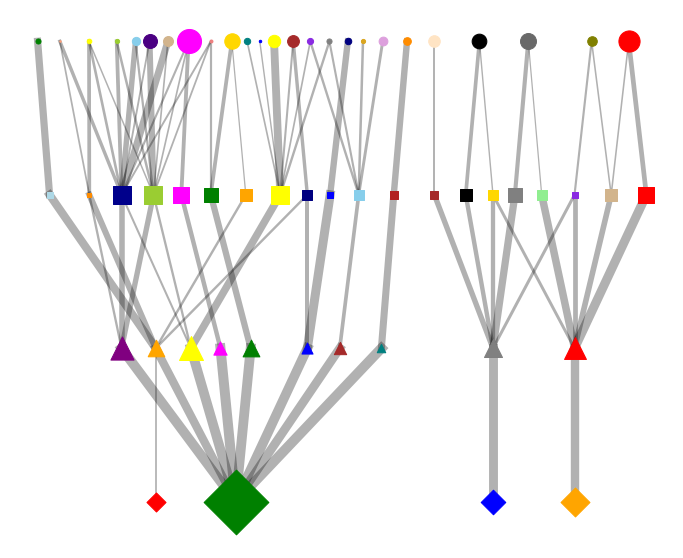

In [57]:
#Build summarized graph for all the tissues and donors
comm_graph1 = graph_connection(data = df, level_0 = 'Community', level_1 = 'Tissue Unit',
                              connection_threshold = 25, level_symbol = ['_m', '_o'])
neighb_graph1 = graph_connection(data = df, level_0 = 'Neighborhood', level_1 = 'Community',
                              connection_threshold = 20, level_symbol = ['_n', '_m'])
cell_graph1 = graph_connection(data = df, level_0 = 'Cell Type', level_1 = 'Neighborhood',
                              connection_threshold = 15, level_symbol = ['_c', '_n'])

level_list = [cell_graph1, neighb_graph1, comm_graph1]
name_list = ['Cell Type','Neighborhood','Community','Tissue Unit' ]
dict_node_size, dict_shape, dict_weight = build_dict(data_levels=level_list, data_names=name_list)
dict_weight

build_graph(hier_list =level_list, connection_list = name_list, pal_color=pal_color1, dict_node_size=dict_node_size, 
            dict_shape=dict_shape, dict_weight=dict_weight, save_path=save_path, save_name='all')

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

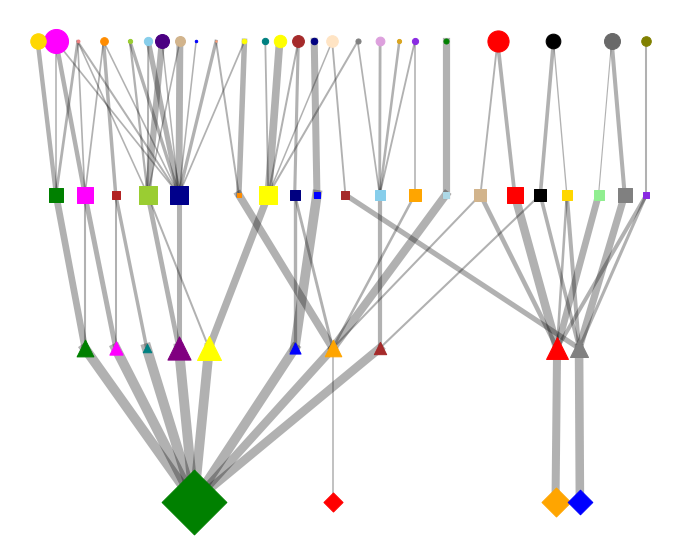

In [59]:
#SB
df_SB = df.loc[df.tissue=='SB']
comm_graph1_SB = graph_connection(data = df_SB, level_0 = 'Community', level_1 = 'Tissue Unit',
                              connection_threshold = 25, level_symbol = ['_m', '_o'])
neighb_graph1_SB = graph_connection(data = df_SB, level_0 = 'Neighborhood', level_1 = 'Community',
                              connection_threshold = 20, level_symbol = ['_n', '_m'])
cell_graph1_SB = graph_connection(data = df_SB, level_0 = 'Cell Type', level_1 = 'Neighborhood',
                              connection_threshold = 15, level_symbol = ['_c', '_n'])

level_list_SB = [cell_graph1_SB, neighb_graph1_SB, comm_graph1_SB]
name_list = ['Cell Type','Neighborhood','Community','Tissue Unit' ]
dict_node_size_SB, dict_shape_SB, dict_weight_SB = build_dict(data_levels=level_list_SB, data_names=name_list)

build_graph(hier_list =level_list_SB, connection_list = name_list, pal_color=pal_color1, dict_node_size=dict_node_size_SB, 
            dict_shape=dict_shape_SB, dict_weight=dict_weight_SB, save_path=save_path, save_name='SB')

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

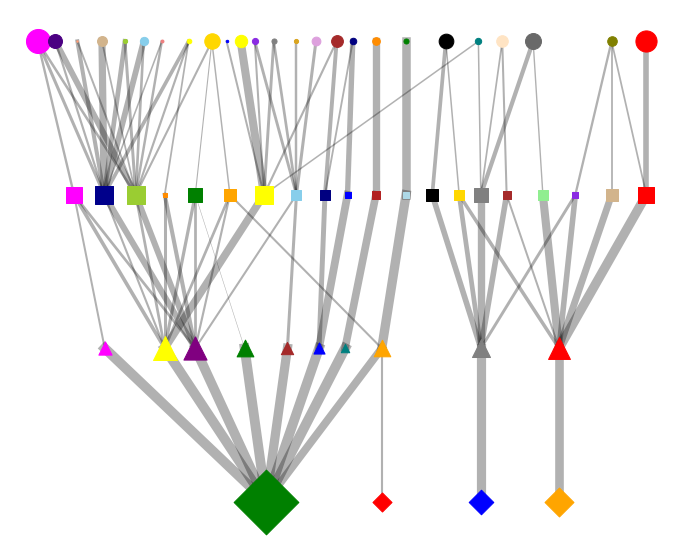

In [60]:
#CL
df_CL = df.loc[df.tissue=='CL']

comm_graph1_CL = graph_connection(data = df_CL, level_0 = 'Community', level_1 = 'Tissue Unit',
                              connection_threshold = 25, level_symbol = ['_m', '_o'])
neighb_graph1_CL = graph_connection(data = df_CL, level_0 = 'Neighborhood', level_1 = 'Community',
                              connection_threshold = 20, level_symbol = ['_n', '_m'])
cell_graph1_CL = graph_connection(data = df_CL, level_0 = 'Cell Type', level_1 = 'Neighborhood',
                              connection_threshold = 15, level_symbol = ['_c', '_n'])

level_list_CL = [cell_graph1_CL, neighb_graph1_CL, comm_graph1_CL]
name_list = ['Cell Type','Neighborhood','Community','Tissue Unit' ]
dict_node_size_CL, dict_shape_CL, dict_weight_CL = build_dict(data_levels=level_list_CL, data_names=name_list)

build_graph(hier_list =level_list_CL, connection_list = name_list, pal_color=pal_color1, dict_node_size=dict_node_size_CL, 
            dict_shape=dict_shape_CL, dict_weight=dict_weight_CL, save_path=save_path, save_name='CL')

In [61]:
def combined_graph(data_input,save_name_l):
    df_tissue=data_input.copy()
    comm_graph1_tissue = graph_connection(data = df_tissue, level_0 = 'Community', level_1 = 'Tissue Unit',
                                  connection_threshold = 25, level_symbol = ['_m', '_o'])
    neighb_graph1_tissue = graph_connection(data = df_tissue, level_0 = 'Neighborhood', level_1 = 'Community',
                                  connection_threshold = 20, level_symbol = ['_n', '_m'])
    cell_graph1_tissue = graph_connection(data = df_tissue, level_0 = 'Cell Type', level_1 = 'Neighborhood',
                                  connection_threshold = 15, level_symbol = ['_c', '_n'])

    level_list_tissue = [cell_graph1_tissue, neighb_graph1_tissue, comm_graph1_tissue]
    name_list = ['Cell Type','Neighborhood','Community','Tissue Unit' ]
    dict_node_size_tissue, dict_shape_tissue, dict_weight_tissue = build_dict(data_levels=level_list_tissue, data_names=name_list)

    build_graph(hier_list =level_list_tissue, connection_list = name_list, pal_color=pal_color1, dict_node_size=dict_node_size_tissue, 
                dict_shape=dict_shape_tissue, dict_weight=dict_weight_tissue, save_path=save_path, save_name=save_name_l)

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

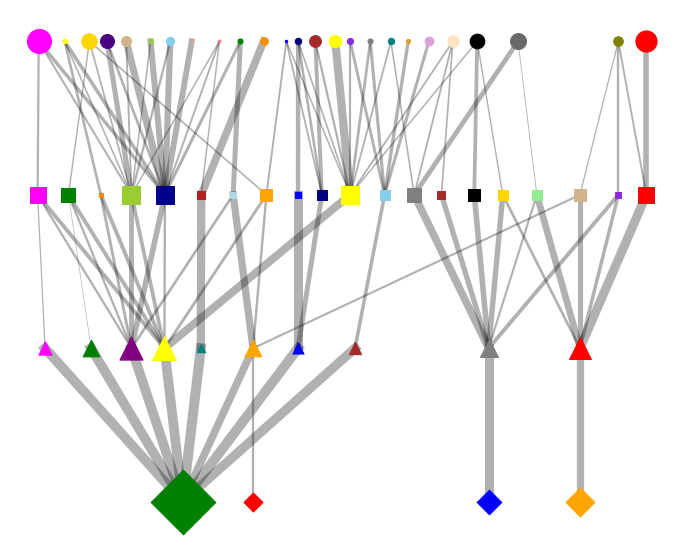

In [62]:
#Do a graph for each tissue
tissue_list = df.Tissue_location.unique().tolist()
df_tissue_0 = df.loc[df.Tissue_location==tissue_list[0]]
combined_graph(data_input = df_tissue_0,save_name_l=tissue_list[0])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

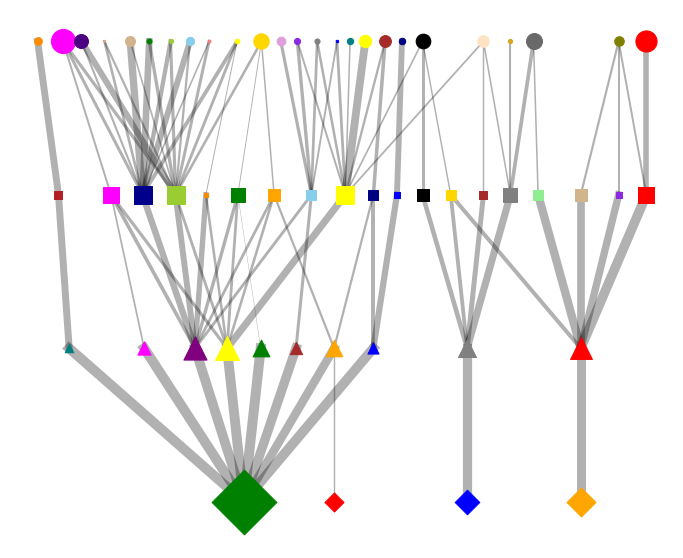

In [63]:
df_tissue_1 = df.loc[df.Tissue_location==tissue_list[1]]
combined_graph(data_input = df_tissue_1,save_name_l=tissue_list[1])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

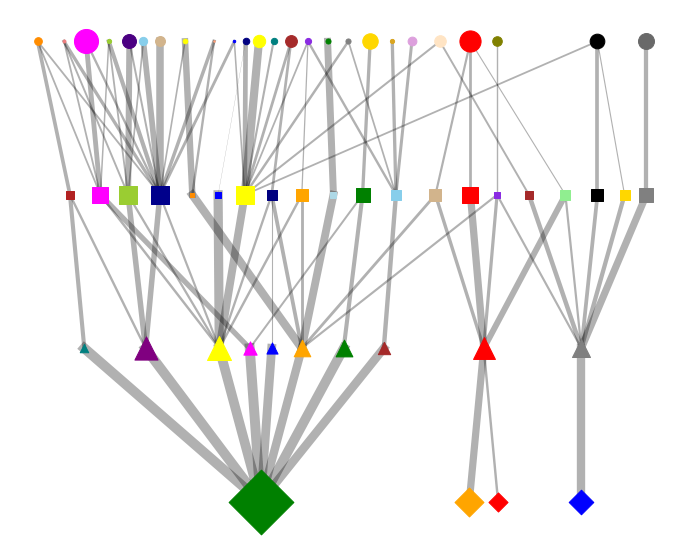

In [64]:
df_tissue_2 = df.loc[df.Tissue_location==tissue_list[2]]
combined_graph(data_input = df_tissue_2,save_name_l=tissue_list[2])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

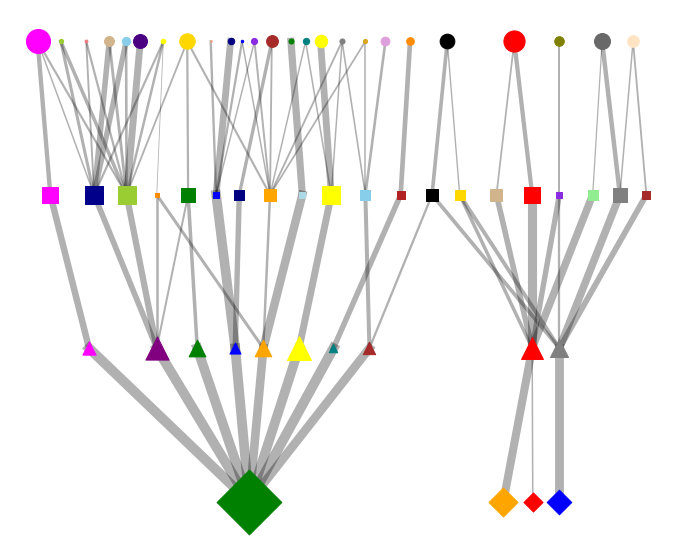

In [65]:
df_tissue_3 = df.loc[df.Tissue_location==tissue_list[3]]
combined_graph(data_input = df_tissue_3,save_name_l=tissue_list[3])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

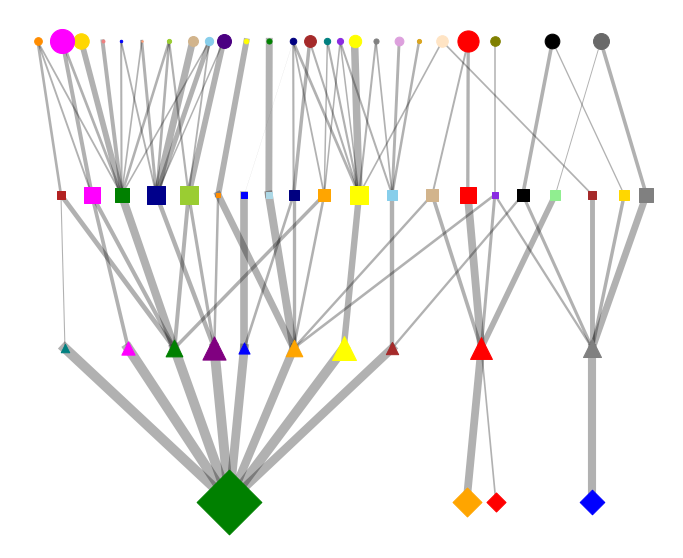

In [66]:
df_tissue_4 = df.loc[df.Tissue_location==tissue_list[4]]
combined_graph(data_input = df_tissue_4,save_name_l=tissue_list[4])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

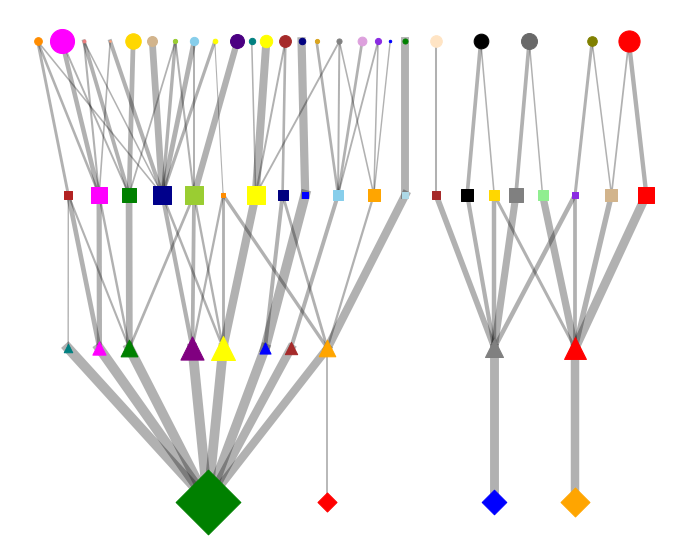

In [67]:
df_tissue_5 = df.loc[df.Tissue_location==tissue_list[5]]
combined_graph(data_input = df_tissue_5,save_name_l=tissue_list[5])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

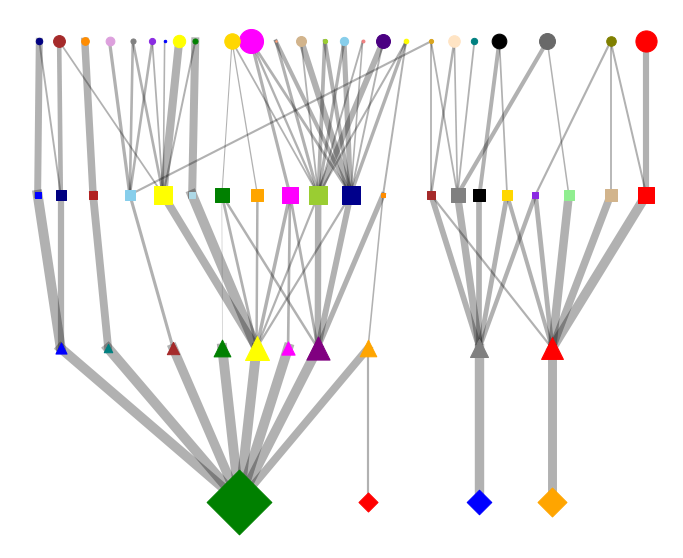

In [68]:
df_tissue_6 = df.loc[df.Tissue_location==tissue_list[6]]
combined_graph(data_input = df_tissue_6,save_name_l=tissue_list[6])

C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\akoya-stanford\Anaconda3\envs\Up_Scanpy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

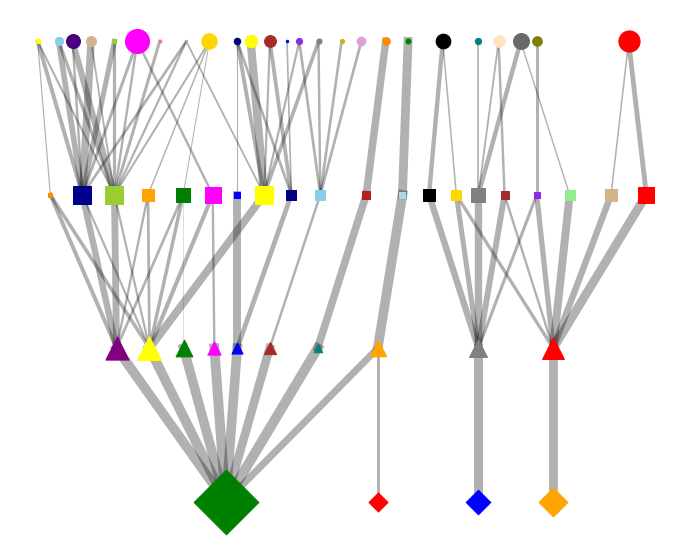

In [69]:
df_tissue_7 = df.loc[df.Tissue_location==tissue_list[7]]
combined_graph(data_input = df_tissue_7,save_name_l=tissue_list[7])

## Try to loop but saves over the top

C:\Users\akoya-stanford\Anaconda3\envs\Scanpy_PAGA\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\akoya-stanford\Anaconda3\envs\Scanpy_PAGA\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\akoya-stanford\Anaconda3\envs\Scanpy_PAGA\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

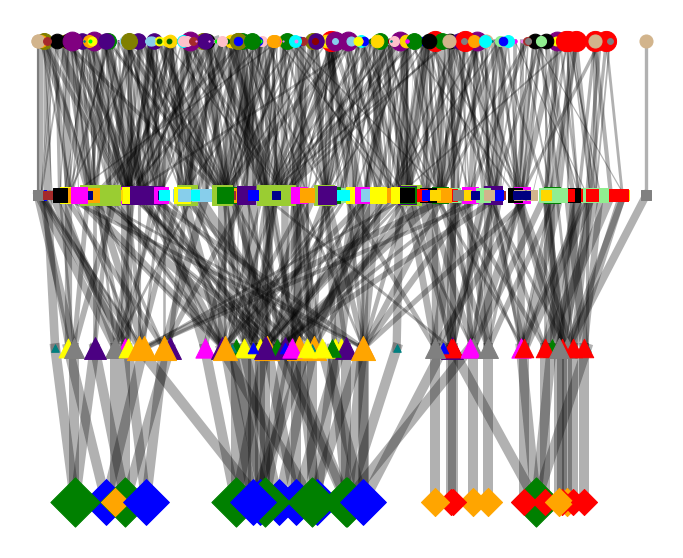

In [326]:
#All tissues
for tissue in df.Tissue_location.unique():
    df_tissue = df.loc[df.Tissue_location==tissue]
    combined_graph(data_input = df_tissue,save_name_l=tissue)

C:\Users\akoya-stanford\Anaconda3\envs\Scanpy_PAGA\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\akoya-stanford\Anaconda3\envs\Scanpy_PAGA\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\akoya-stanford\Anaconda3\envs\Scanpy_PAGA\lib\site-packages\pandas\core\frame.py:4298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

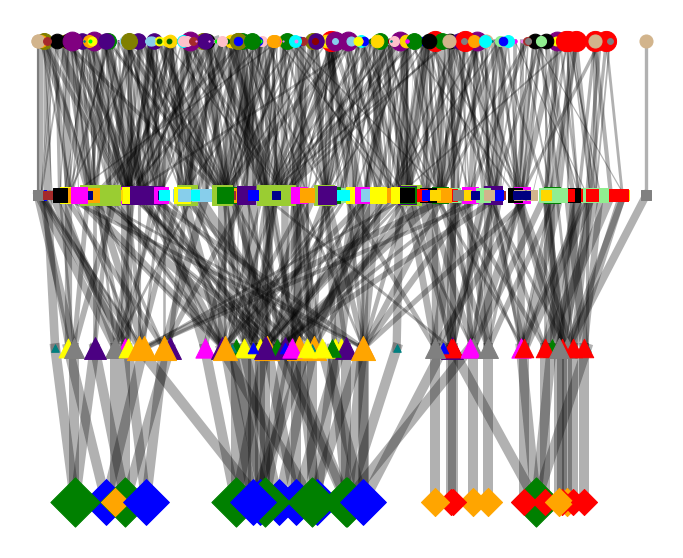

In [323]:
#All tissues
for tissue in df.Tissue_location.unique():
    
    df_tissue = df.loc[df.Tissue_location==tissue]
    comm_graph1_tissue = graph_connection(data = df_tissue, level_0 = 'Community', level_1 = 'Tissue Unit',
                                  connection_threshold = 35, level_symbol = ['_m', '_o'])
    neighb_graph1_tissue = graph_connection(data = df_tissue, level_0 = 'Neighborhood', level_1 = 'Community',
                                  connection_threshold = 25, level_symbol = ['_n', '_m'])
    cell_graph1_tissue = graph_connection(data = df_tissue, level_0 = 'Cell Type', level_1 = 'Neighborhood',
                                  connection_threshold = 15, level_symbol = ['_c', '_n'])

    level_list_tissue = [cell_graph1_tissue, neighb_graph1_tissue, comm_graph1_tissue]
    name_list = ['Cell Type','Neighborhood','Community','Tissue Unit' ]
    dict_node_size_tissue, dict_shape_tissue, dict_weight_tissue = build_dict(data_levels=level_list_tissue, data_names=name_list)

    build_graph(hier_list =level_list_tissue, connection_list = name_list, pal_color=pal_color1, dict_node_size=dict_node_size_tissue, 
                dict_shape=dict_shape_tissue, dict_weight=dict_weight_tissue, save_path=save_path, save_name='tissue_'+tissue)